<a href="https://colab.research.google.com/github/pea-sys/Til/blob/master/Qunadl_API_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[参考](https://ntguardian.wordpress.com/2018/07/17/stock-data-analysis-python-v2/)

In [1]:
!pip install quandl
!pip install pandas-datareader
!pip install mpl-finance

In [2]:
import quandl
quandl.ApiConfig.api_key = 'SecretKEY'

#Getting Data from Quandl

In [3]:
import pandas as pd
import datetime
 
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2014,1,1)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
s = "AAPL"
apple = quandl.get("WIKI/" + s, start_date=start, end_date=end)
 
apple.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-01-02,555.68,557.03,552.021,553.1300,8381600.0,0.0,1.0,73.862376,74.041821,73.376012,73.523423,58671200.0
2014-01-03,552.86,553.70,540.430,540.9800,14016700.0,0.0,1.0,73.487534,73.599189,71.835308,71.908415,98116900.0
2014-01-06,537.45,546.80,533.600,543.9300,14736100.0,0.0,1.0,71.439198,72.682024,70.927447,72.300536,103152700.0
2014-01-07,544.32,545.96,537.925,540.0375,11328900.0,0.0,1.0,72.352376,72.570369,71.502337,71.783135,79302300.0
2014-01-08,538.81,545.56,538.690,543.4600,9233200.0,0.0,1.0,71.619973,72.517200,71.604022,72.238063,64632400.0



[各項目の説明]
*   Open・・・始値
*   High・・・高値
*   Low ・・・低値
*   Close・・・終値
*   Volume・・・出来高
*   Adj・・・調整後

# Visualizing Stock Data


Populating the interactive namespace from numpy and matplotlib


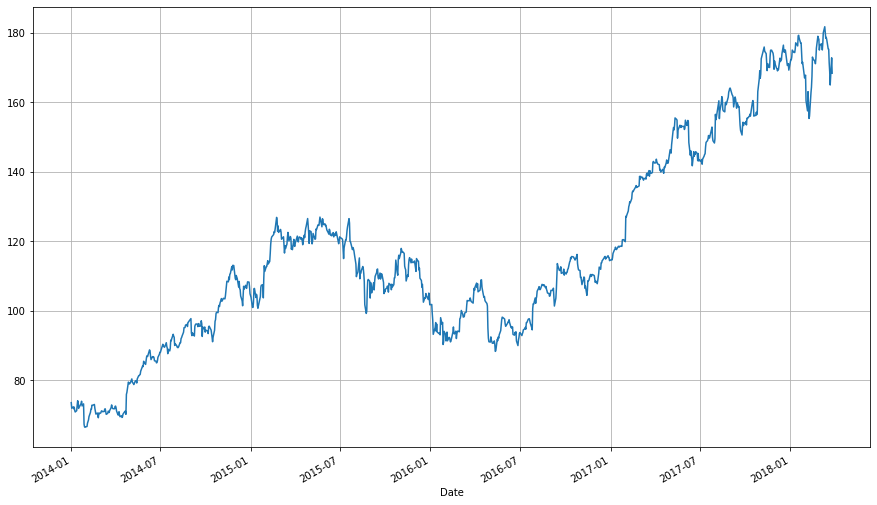

In [4]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj. Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

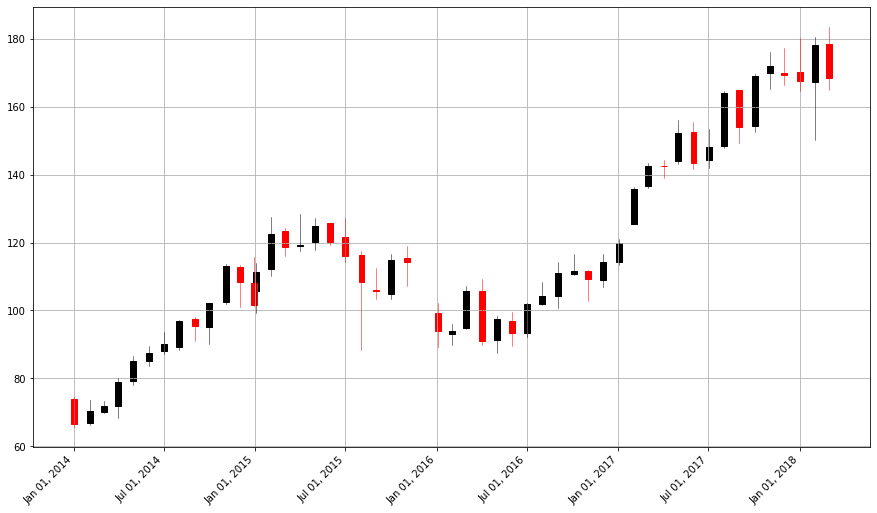

In [5]:
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple, adj=True, stick="month")

In [6]:
microsoft, google = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["MSFT", "GOOGL"])
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj. Close"],
                      "MSFT": microsoft["Adj. Close"],
                      "GOOGL": google["Adj. Close"]})
 
stocks.head()

,AAPL,MSFT,GOOGL
Date,,,
2014-01-02,73.523423,33.532800,558.283367
2014-01-03,71.908415,33.307202,554.210796
2014-01-06,72.300536,32.603338,560.389870
2014-01-07,71.783135,32.856007,571.193219
2014-01-08,72.238063,32.269454,572.381888


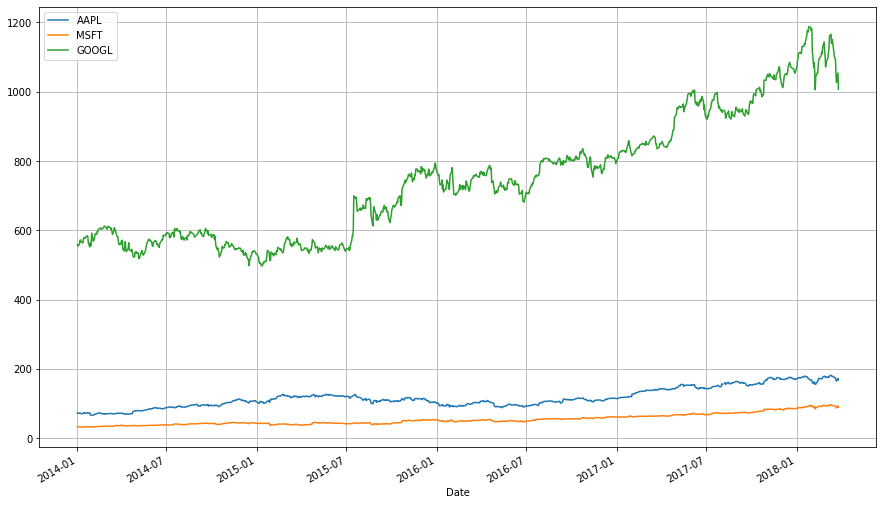

In [7]:
stocks.plot(grid = True)

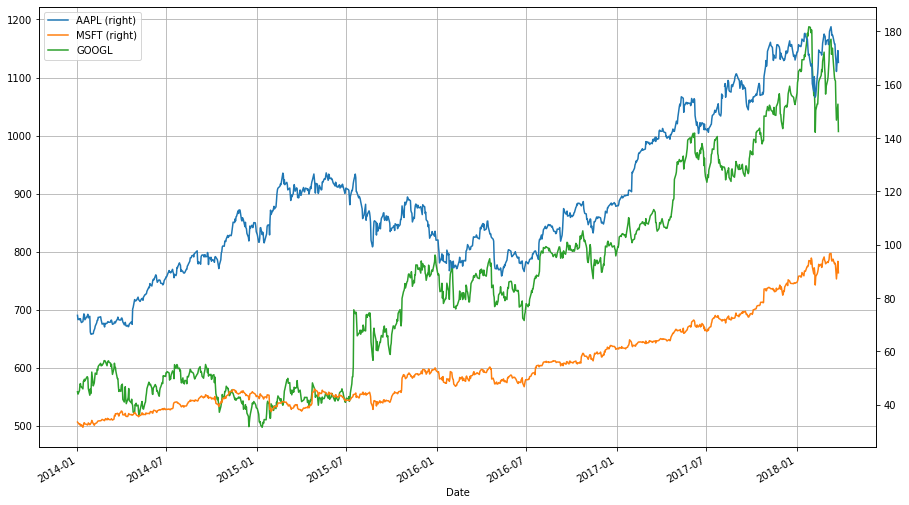

In [8]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [9]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head() - 1

,AAPL,MSFT,GOOGL
Date,,,
2014-01-02,0.000000,0.000000,0.000000
2014-01-03,-0.021966,-0.006728,-0.007295
2014-01-06,-0.016633,-0.027718,0.003773
2014-01-07,-0.023670,-0.020183,0.023124
2014-01-08,-0.017482,-0.037675,0.025253


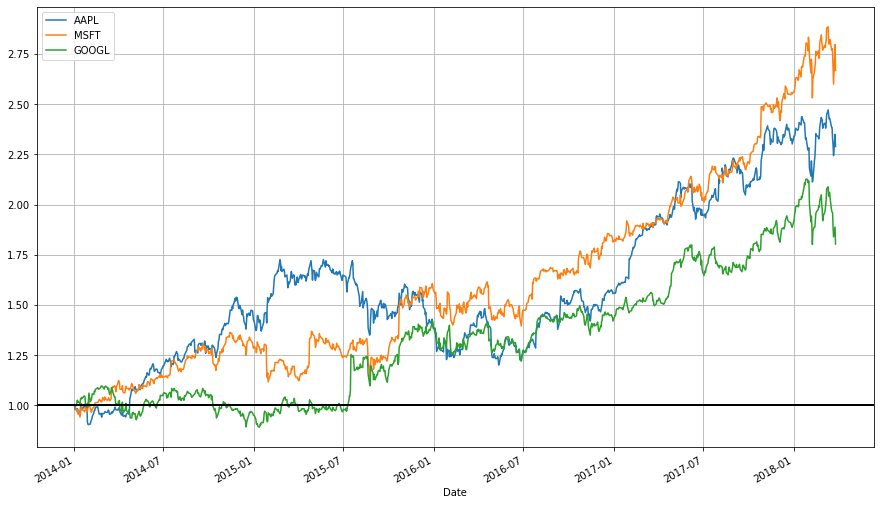

In [10]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)


In [11]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,MSFT,GOOGL
Date,,,
2014-01-02,NaN,NaN,NaN
2014-01-03,-0.022211,-0.006750,-0.007322
2014-01-06,0.005438,-0.021359,0.011088
2014-01-07,-0.007182,0.007720,0.019095
2014-01-08,0.006318,-0.018014,0.002079


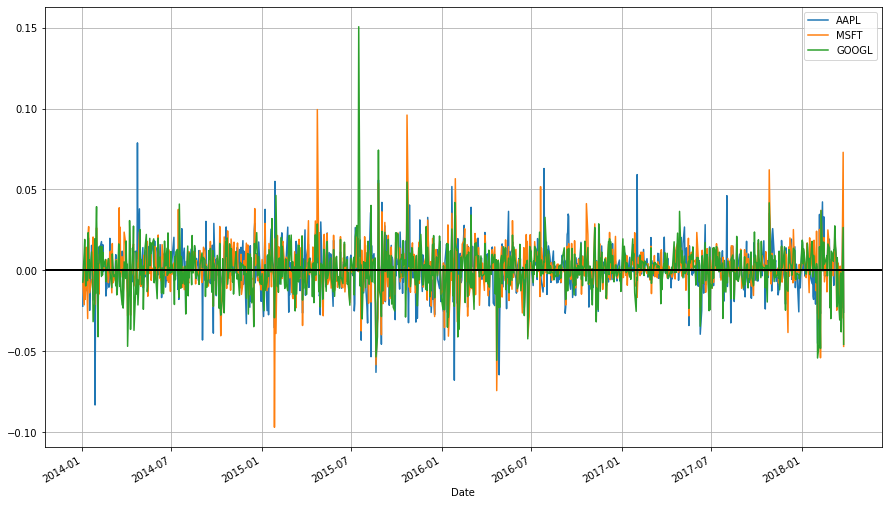

In [12]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

In [14]:
 pd.read_csv("HistoricalQuotes.csv").sample()

,Date,Close/Last,Volume,Open,High,Low
14,09/16/2020,338.82,82211260,341.51,343.06,338.52


#Classical Risk Metrics

In [15]:
stock_change_apr = stock_change * 252 * 100    # There are 252 trading days in a year; the 100 converts to percentages
stock_change_apr.tail()

,AAPL,MSFT,GOOGL
Date,,,
2018-03-21,-577.463148,-176.499833,-41.428450
2018-03-22,-359.355133,-743.873619,-958.986777
2018-03-23,-589.663945,-743.366326,-644.666593
2018-03-26,1168.762361,1839.012005,667.149083
2018-03-27,-654.582257,-1185.615651,-1153.197522


In [16]:
tbill = quandl.get("FRED/TB3MS", start_date=start, end_date=end)
tbill.tail()

,Value
Date,
2020-05-01,0.13
2020-06-01,0.16
2020-07-01,0.13
2020-08-01,0.10
2020-09-01,0.11


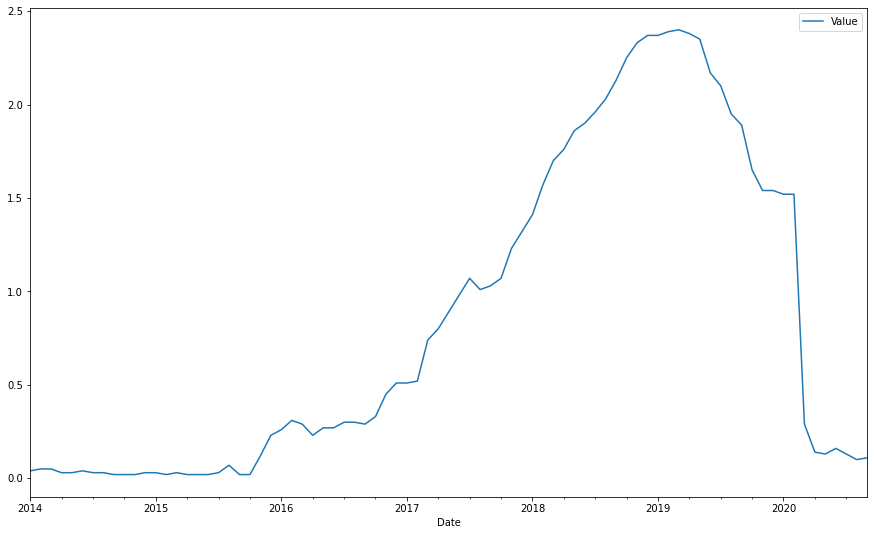

In [17]:
tbill.plot()

In [18]:
rrf = tbill.iloc[-1, 0]    # Get the most recent Treasury Bill rate
rrf

0.11

#Moving Averages

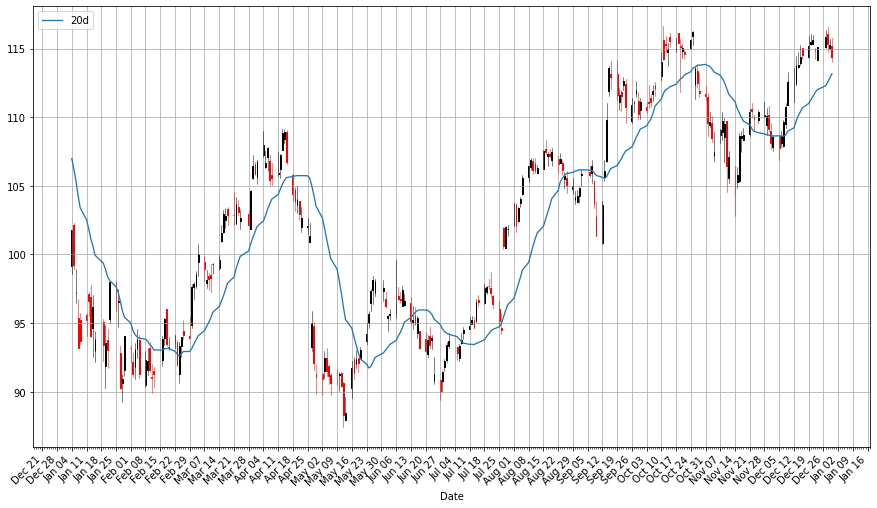

In [19]:
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = "20d", adj=True)


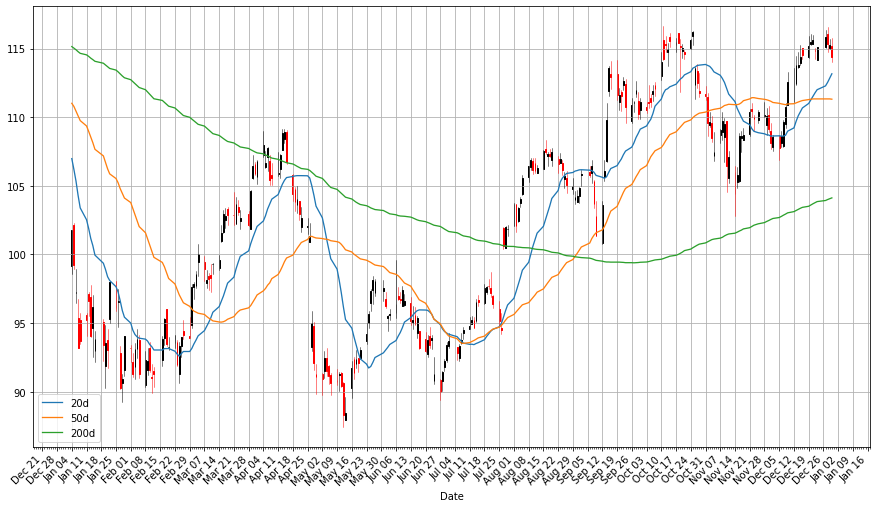

In [20]:
apple["50d"] = np.round(apple["Adj. Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Adj. Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = ["20d", "50d", "200d"], adj=True)


#Trading Strategy
私たちの関心事は、取引戦略を設計し、評価することです。

どんなトレーダーでも、一つの取引にどれだけの資金を賭けるかを決定する一連のルールを持っていなければなりません。例えば、あるトレーダーは、いかなる状況下でも、トレードでポートフォリオの10％以上のリスクを負わないと決めているかもしれません。さらに、どのようなトレードでも、トレーダーは、利益か損失かのどちらかのために、いつポジションを終了するかを決定する条件のセットである出口戦略を持っていなければなりません。トレーダーは、ポジションを離れるためにトレーダーを誘導する最小利益であるターゲットを設定することができます。同様に、トレーダーは許容できる最大損失を設定することができます。潜在的な損失がこの金額を超えた場合、トレーダーはそれ以上の損失を防ぐためにポジションを終了します。ここでは、特定の取引に関与するポートフォリオの金額が一定の割合であると仮定します。

ここでは、移動平均クロスオーバー戦略を実演します。ここでは、2 つの移動平均を使用します。戦略は次のとおりです。

速い移動平均線が遅い移動平均線と交差したときに資産を取引する。
速い移動平均線が遅い移動平均線と交差したら取引を終了する。
速い移動平均線が遅い移動平均線の下から上にクロスしたときにトレードを促し、後で速い移動平均線が遅い移動平均線の下にクロスしたときにトレードを終了します。

これで完全な戦略が完成しました。しかし、これを使おうと決める前に、まずこのストラテジーの品質を評価してみましょう。そのための通常の手段はバックテストであり、過去のデータに基づいてそのストラテジーがどれだけ利益を上げているかを見ることです。例えば、上のチャートのApple株のパフォーマンスを見てみると、20日移動平均線が速い移動平均線、50日移動平均線が遅い移動平均線であれば、このストラテジーはあまり利益を上げているようには見えません（少なくとも常にロングポジションを取っている場合はそうではありません）。

バックテストのタスクを自動化できるかどうか見てみましょう。まず、20日平均線が50日平均線を下回ったときと、その逆の場合を特定します。

In [21]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,20d,50d,200d,20d-50d
Date,,,,,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0,176.94,172.57,162.68,4.37
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0,176.76,172.46,162.75,4.30
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0,176.23,172.27,162.81,3.96
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0,175.92,172.22,162.91,3.70
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0,175.41,172.05,162.98,3.36


この差の符号をレジームと呼びます。つまり、高速移動平均線が低速移動平均線を上回れば、これは強気のレジーム（ブルズ・ルール）であり、高速移動平均線が低速移動平均線を下回れば弱気のレジーム（ベアズ・ルール）となります。私は以下のコードでレジームを識別しています。

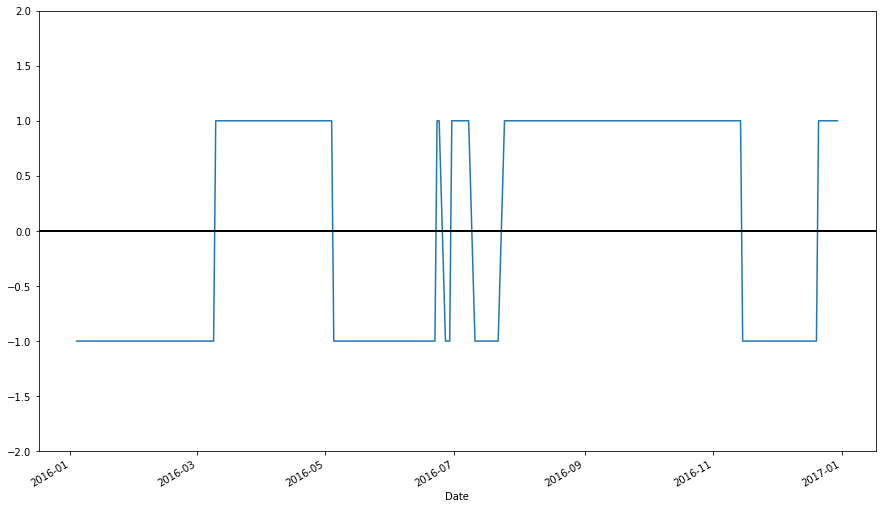

In [22]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-04':'2016-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)


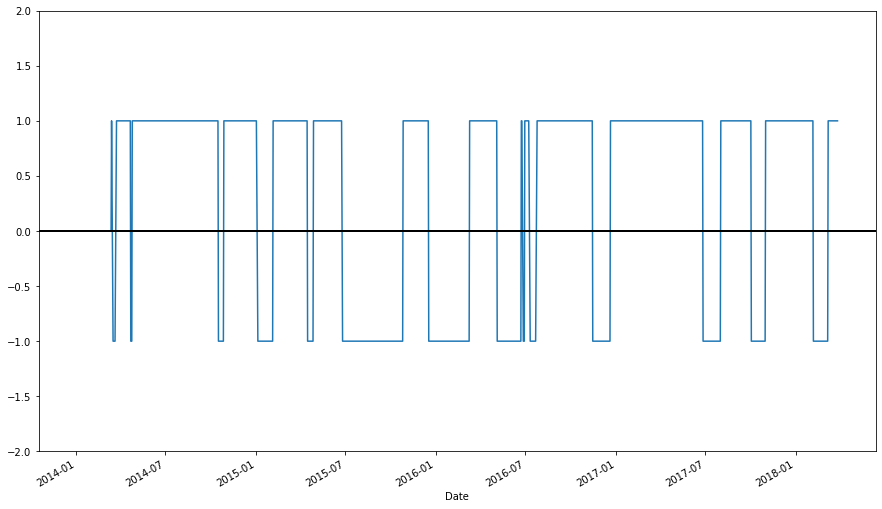

In [23]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [24]:
apple["Regime"].value_counts()

 1    690
-1    324
 0     50
Name: Regime, dtype: int64

In [25]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.loc[:, "Regime"].iloc[-1]
apple.loc[:, "Regime"].iloc[-1] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.loc[:, "Regime"].iloc[-1] = regime_orig
apple.tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0,176.94,172.57,162.68,4.37,1,0.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0,176.76,172.46,162.75,4.30,1,0.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0,176.23,172.27,162.81,3.96,1,0.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0,175.92,172.22,162.91,3.70,1,0.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0,175.41,172.05,162.98,3.36,1,-1.0


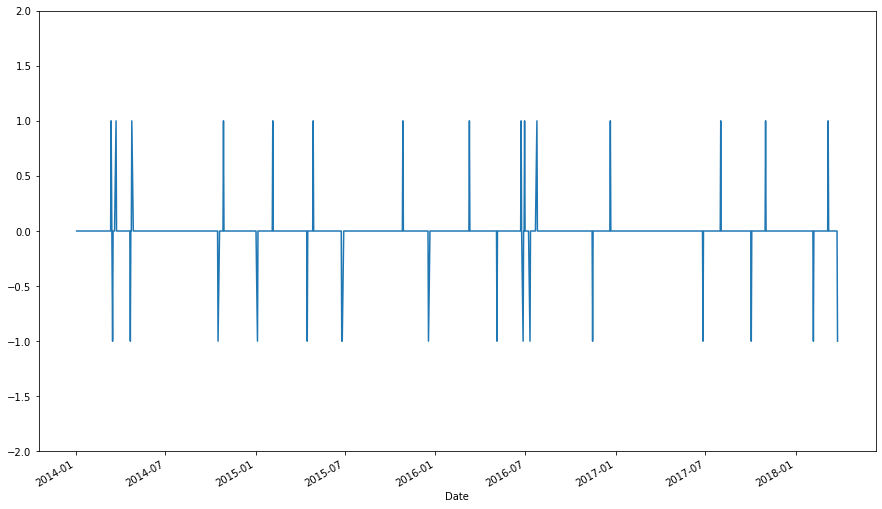

In [26]:
apple["Signal"].plot(ylim = (-2, 2))


In [27]:
apple["Signal"].value_counts()

 0.0    1032
-1.0      16
 1.0      15
Name: Signal, dtype: int64

Apple株を23回買い、23回売るとします。一方、ロングポジションが終了するたびにロングポジションからショートポジションにピボットすると、合計23回のトレードを行うことになります。(取引の頻度が高いことが必ずしも良いことではないことに留意してください。)

なぜなら、高速移動平均線が低速移動平均線を上回ったときの一瞬でも取引を誘発し、その結果、取引はすぐに終了してしまうからです（これは、現実的にはすべての取引にはすぐに収益を侵食する手数料が伴うため、単純に悪いことではありません）。さらに、すべての強気レジームはすぐに弱気レジームに移行します。もし、強気と弱気の両方の賭けを可能にする取引システムを構築していたとしたら、ある取引の終了はすぐに市場の反対方向に賭ける新しい取引を誘発することになりますが、これもまた不器用なようです。より良いシステムには、市場が特定の方向に動いているという証拠が必要です。しかし、ここではその詳細については触れません。

では、買いと売りのたびに株価がどうなっているのかを確認してみましょう。

In [28]:
apple.loc[apple["Signal"] == -1, "Close"]

Date
2014-03-17    526.740
2014-04-22    531.699
2014-10-17     97.670
2015-01-05    106.250
2015-04-16    126.170
2015-06-25    127.500
2015-06-26    126.750
2015-12-18    106.030
2016-05-05     93.240
2016-06-27     92.040
2016-07-11     96.980
2016-11-15    107.110
2017-06-27    143.740
2017-10-03    154.480
2018-02-06    163.030
2018-03-27    168.340
Name: Close, dtype: float64

In [29]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2014-03-14,70.158156,1,Buy
2014-03-17,70.432269,-1,Sell
2014-03-24,72.097002,1,Buy
2014-04-22,71.095354,-1,Sell
2014-04-25,76.476120,1,Buy
2014-10-17,92.387441,-1,Sell
2014-10-28,100.966883,1,Buy
2015-01-05,100.937944,-1,Sell
2015-02-05,114.390004,1,Buy


In [30]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,Price,Profit,End Date
Date,,,
2014-03-14,70.158156,0.274113,2014-03-17
2014-03-24,72.097002,-1.001648,2014-04-22
2014-04-25,76.476120,15.911321,2014-10-17
2014-10-28,100.966883,-0.028939,2015-01-05
2015-02-05,114.390004,5.941719,2015-04-16
2015-04-28,124.518583,-2.413598,2015-06-25
2015-10-27,110.198438,-7.757693,2015-12-18
2016-03-10,98.271427,-7.149132,2016-05-05
2016-06-23,93.917337,-3.967788,2016-06-27


では、100万ドルのシミュレーションポートフォリオを作成して、設定したルールに従って、どのように振る舞うかを見てみましょう。これには以下が含まれます。

ポートフォリオの10％のみに投資する。
損失が取引額の20％を超えた場合は、ポジションから退出します。
シミュレーションを行う際には、以下のことに留意してください。

取引は100銘柄のバッチで行われます。
損切りルールでは、価格が指定された水準を下回った瞬間に、その銘柄を売却する注文を出すことになります。したがって、この期間の安値がストップロスを発動するのに十分な安値になっているかどうかを確認する必要があります。現実的には、プットオプションを購入しない限り、ストップロスで設定した価格で株式を売却できる保証はありませんが、シンプルにするために、これを売却価格として使用します。
取引には必ずブローカーへの手数料が伴いますが、これは計上しなければなりません。私はここではそうしません。
ここでは、バックテストがどのように見えるかもしれません。

In [31]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_long_profits.index,
                            "End": apple_long_profits["End Date"]})
apple_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple.loc[x["Start"]:x["End"], "Adj. Low"]), axis = 1)
apple_long_profits

,Price,Profit,End Date,Low
Date,,,,
2014-03-14,70.158156,0.274113,2014-03-17,69.932180
2014-03-24,72.097002,-1.001648,2014-04-22,68.371743
2014-04-25,76.476120,15.911321,2014-10-17,75.409086
2014-10-28,100.966883,-0.028939,2015-01-05,99.652062
2015-02-05,114.390004,5.941719,2015-04-16,112.949876
2015-04-28,124.518583,-2.413598,2015-06-25,117.651750
2015-10-27,110.198438,-7.757693,2015-12-18,102.228192
2016-03-10,98.271427,-7.149132,2016-05-05,89.752692
2016-06-23,93.917337,-3.967788,2016-06-27,89.421814


In [32]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,Start Port. Value,End Port. Value,End Date,Shares,Share Price,Trade Value,Profit per Share,Total Profit,Stop-Loss Triggered
2014-03-14,1.000000e+06,1.000384e+06,2014-03-17,1400.0,70.158156,98221.418093,0.274113,383.757851,0.0
2014-03-24,1.000384e+06,9.990816e+05,2014-04-22,1300.0,72.097002,93726.102689,-1.001648,-1302.142538,0.0
2014-04-25,9.990816e+05,1.019766e+06,2014-10-17,1300.0,76.476120,99418.956531,15.911321,20684.716976,0.0
2014-10-28,1.019766e+06,1.019737e+06,2015-01-05,1000.0,100.966883,100966.883069,-0.028939,-28.938709,0.0
2015-02-05,1.019737e+06,1.024491e+06,2015-04-16,800.0,114.390004,91512.002863,5.941719,4753.374836,0.0
2015-04-28,1.024491e+06,1.022560e+06,2015-06-25,800.0,124.518583,99614.866549,-2.413598,-1930.878038,0.0
2015-10-27,1.022560e+06,1.015578e+06,2015-12-18,900.0,110.198438,99178.594062,-7.757693,-6981.924031,0.0
2016-03-10,1.015578e+06,1.008429e+06,2016-05-05,1000.0,98.271427,98271.426868,-7.149132,-7149.132171,0.0
2016-06-23,1.008429e+06,1.004461e+06,2016-06-27,1000.0,93.917337,93917.337198,-3.967788,-3967.787607,0.0
2016-06-30,1.004461e+06,1.005810e+06,2016-07-11,1000.0,93.428693,93428.693404,1.348657,1348.656871,0.0


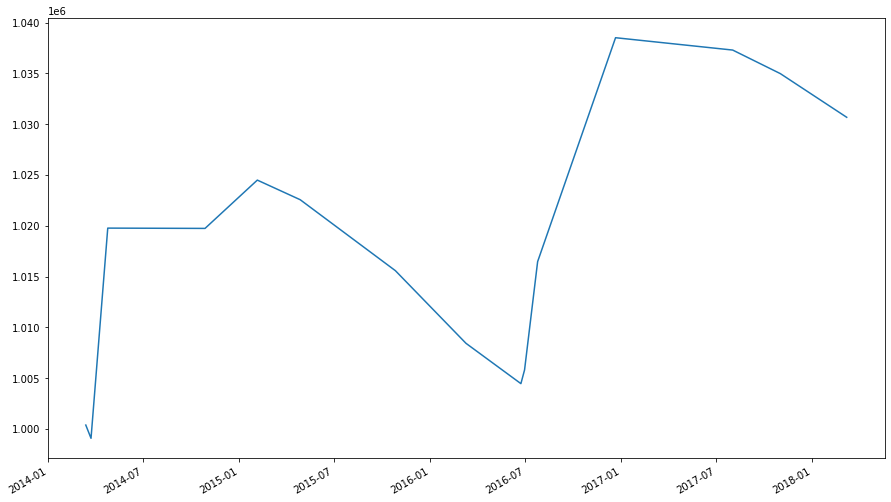

In [33]:
	
apple_backtest["End Port. Value"].plot()

私たちのポートフォリオの価値は、約6年間で13％成長しました。ポートフォリオのわずか10％が単一の取引に関与していたことを考えると、これは悪いパフォーマンスではありません。

この戦略は、損失が取引価値の20％を超えることを許さないという私たちのルールに決してつながらなかったことに注目してください。簡単にするために、バックテストではこのルールは無視します。

より現実的なポートフォリオは、1つの銘柄だけに価値の10％を賭けることはありません。より現実的なポートフォリオは、複数の銘柄に投資することを検討します。複数の企業を含む複数の取引が同時に行われている可能性があり、ポートフォリオの大部分は現金ではなく株式に投資することになります。複数のストップに投資し、移動平均線がクロスしたときにのみ（ストップロスではなく）退場することになったので、バックテストのアプローチを変更する必要があります。例えば、1つのパンダのDataFrameを使用して、検討中のすべての銘柄の売買注文を格納することになります。

複数銘柄の注文データを作成するための関数と、バックテストを行うための関数を書きました。

In [35]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
 
    :return: pandas DataFrame containing stock orders
 
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].loc[:, "Regime"].iloc[-1]
        s[1].loc[:, "Regime"].iloc[-1] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].loc[:, "Regime"].iloc[-1] = regime_orig
 
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 
 
def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
 
    :return: pandas DataFrame with backtesting results
 
    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
 
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
 
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared
 
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
 
        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
 
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results
 
# Get more stocks
(microsoft, google, facebook, twitter, netflix,
amazon, yahoo, ge, qualcomm, ibm, hp) = (quandl.get("WIKI/" + s, start_date=start,
                                                                         end_date=end) for s in ["MSFT", "GOOG", "FB", "TWTR",
                                                                                                 "NFLX", "AMZN", "YHOO", "GE",
                                                                                                 "QCOM", "IBM", "HPQ"])

In [36]:
signals = ma_crossover_orders([("AAPL", apple),
                              ("MSFT",  microsoft),
                              ("GOOG",  google),
                              ("FB",    facebook),
                              ("TWTR",  twitter),
                              ("NFLX",  netflix),
                              ("AMZN",  amazon),
                              ("YHOO",  yahoo),
                              ("GE",    ge),
                              ("QCOM",  qualcomm),
                              ("IBM",   ibm),
                              ("HPQ",   hp)],
                            fast = 20, slow = 50)
signals


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

Price  Regime Signal
Date       Symbol                           
2014-03-14 AAPL     70.158156    -1.0   Sell
           AMZN    373.740000    -1.0   Sell
           FB       67.720000     1.0    Buy
           GE       22.351117    -1.0   Sell
           HPQ      11.954422     1.0    Buy
...                       ...     ...    ...
2018-03-27 IBM     151.910000    -1.0    Buy
           MSFT     89.470000     1.0   Sell
           NFLX    300.690000     1.0   Sell
           QCOM     54.840000    -1.0    Buy
           TWTR     28.070000     1.0   Sell

[281 rows x 3 columns]

In [37]:
bk = backtest(signals, 1000000)
bk

Start Cash      End Cash  ...  Profit per Share Total Profit
Date       Symbol                              ...                               
2014-03-14 AAPL    1.000000e+06  1.000000e+06  ...          0.000000          0.0
           AMZN    1.000000e+06  1.000000e+06  ...          0.000000          0.0
           FB      1.000000e+06  9.051920e+05  ...          0.000000          0.0
           GE      9.051920e+05  9.051920e+05  ...          0.000000          0.0
           HPQ     9.051920e+05  8.059703e+05  ...          0.000000          0.0
...                         ...           ...  ...               ...          ...
2018-03-27 IBM     9.862618e+05  9.862618e+05  ...          6.798221          0.0
           MSFT    9.862618e+05  1.156255e+06  ...         31.491454          0.0
           NFLX    1.156255e+06  1.336669e+06  ...         91.380000          0.0
           QCOM    1.336669e+06  1.336669e+06  ...        -13.200000         -0.0
           TWTR    1.336669e+06  1.541580e+06  ...         11.090000          0.0

[281 rows x 9 columns]

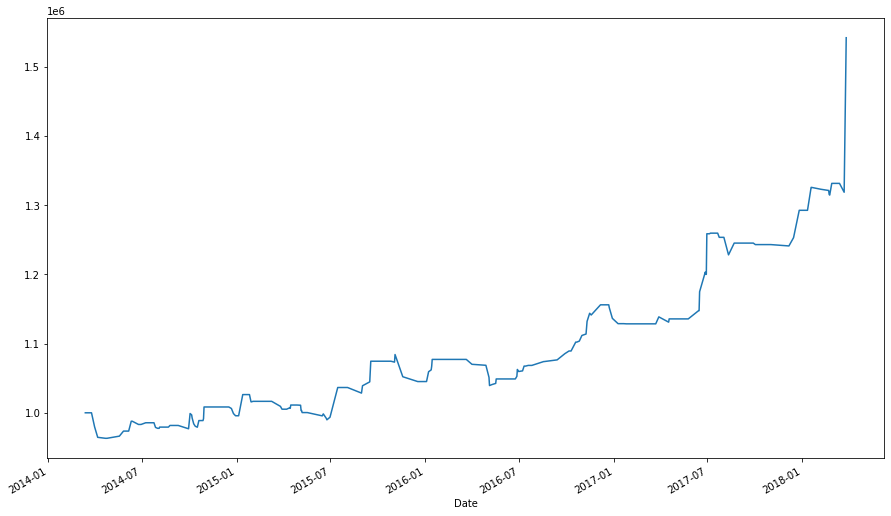

In [38]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()


12（テック）銘柄のリストの中のどれかに投資できるより現実的なポートフォリオは、最終的には100％程度の伸びを示しています。これはどのように良いですか？表面上は悪くないが、我々はより良いことをしている可能性が表示されます。